In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


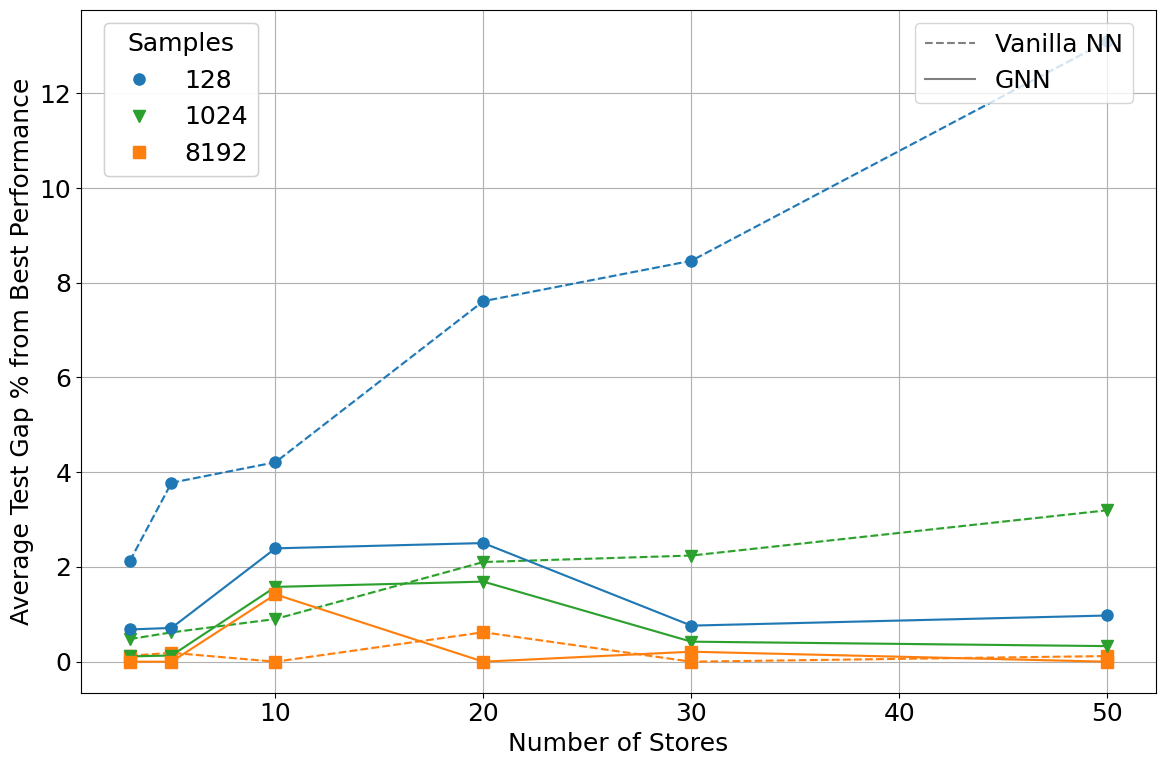

In [7]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_one_warehouse_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green  
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Circle
    1024: "v",         # Down triangle
    8192: "s",         # Square
}

linestyle_scheme = {
    "Vanilla NN": "--",  # Dashed
    "GNN": "-",         # Solid
}
# Define paths for each architecture
# Define architectures with their path patterns
architectures = {
    "Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_warehouse',
    "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define number of stores and sample sizes
n_stores = [3, 5, 10, 20, 30, 50]
sample_sizes = [128, 1024, 8192]

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    for n_store in n_stores:
        path = path_fn(n_store)
        for sample_size in sample_sizes:
            df = results_interpretor.make_table({1: path},
                {'train_dev_sample_and_batch_size': [sample_size],
                 'store_underage_cost': [9],
                 'store_lead_time': [[2, 6]],
                 'samples': [1],
                 'n_stores': [n_store]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
                test_loss_limit = 100)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['n_stores'] = n_store
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate gap percentage using best performing loss for each n_stores
stats_by_arch_sample_and_stores = {}
for n_store in n_stores:
    store_data = df[df['n_stores'] == n_store].copy()  # Create copy to avoid SettingWithCopyWarning
    if store_data.empty:
        continue
    best_test_loss = store_data['Test Loss'].min()
    store_data.loc[:, 'Gap %'] = ((store_data['Test Loss'] - best_test_loss) / best_test_loss) * 100
    
    for arch in store_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_stores:
                stats_by_arch_sample_and_stores[key] = []
                
            sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                   (store_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_arch_sample_and_stores[key].append({
                    'n_stores': n_store,
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })
# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for (arch, sample_size), stats in stats_by_arch_sample_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Convert pandas series to numpy arrays before plotting
        n_stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(n_stores_array, mean_gap_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=8)
        
        plt.fill_between(n_stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[sample_size],
                        alpha=0.1)
# Create separate legend entries for architectures and sample sizes
arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
              for arch in linestyle_scheme.keys()]
sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                            linestyle='none', label=f'{size}', markersize=8)
                 for size in color_scheme.keys()]

plt.xlabel('Number of Stores', fontsize=FONTSIZE)
plt.ylabel('Average Test Gap % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)

# Create two separate legends
# Right legend for architectures
legend1 = plt.legend(handles=arch_lines, 
                    bbox_to_anchor=(0.99, 1),
                    loc='upper right', 
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend1)

# Left legend for sample sizes with title
legend2 = plt.legend(handles=sample_patches,
                    title='Samples',
                    bbox_to_anchor=(0.01, 1),
                    loc='upper left',
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [4]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,store_underage_cost,store_lead_time,samples,n_stores,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path
0,1,Vanilla NN,128,Vanilla NN,9,"(2, 6)",1,3,0.0010,5.034322,6.020340,6.031924,27,/user/ml4723/Prj/NIC/ray_results/finals_one_wa...
1,1,Vanilla NN,1024,Vanilla NN,9,"(2, 6)",1,3,0.0010,5.568020,5.672354,5.659840,27,/user/ml4723/Prj/NIC/ray_results/finals_one_wa...
2,1,Vanilla NN,8192,Vanilla NN,9,"(2, 6)",1,3,0.0010,5.573746,5.624799,5.628667,27,/user/ml4723/Prj/NIC/ray_results/finals_one_wa...
3,1,Vanilla NN,128,Vanilla NN,9,"(2, 6)",1,5,0.0010,5.175130,5.547515,5.568125,27,/user/ml4723/Prj/NIC/ray_results/finals_one_wa...
4,1,Vanilla NN,1024,Vanilla NN,9,"(2, 6)",1,5,0.0010,5.234839,5.296577,5.298601,27,/user/ml4723/Prj/NIC/ray_results/finals_one_wa...
5,1,Vanilla NN,8192,Vanilla NN,9,"(2, 6)",1,5,0.0010,5.256617,5.307664,5.305731,26,/user/ml4723/Prj/NIC/ray_results/finals_one_wa...
6,1,Vanilla NN,128,Vanilla NN,9,"(2, 6)",1,10,0.0010,5.470228,6.180755,6.177288,27,/user/ml4723/Prj/NIC/ray_results/finals_one_wa...
7,1,Vanilla NN,1024,Vanilla NN,9,"(2, 6)",1,10,0.0010,5.667341,5.878231,5.854521,27,/user/ml4723/Prj/NIC/ray_results/finals_one_wa...
8,1,Vanilla NN,8192,Vanilla NN,9,"(2, 6)",1,10,0.0010,5.708459,5.782490,5.767661,27,/user/ml4723/Prj/NIC/ray_results/finals_one_wa...
9,1,Vanilla NN,128,Vanilla NN,9,"(2, 6)",1,20,0.0010,5.453488,6.556766,6.653672,27,/user/ml4723/Prj/NIC/ray_results/finals_one_wa...


In [5]:
print(df[df["n_stores"] == 10].to_string())

    # of stores hyperparam_name  train_dev_sample_and_batch_size Architecture Class  store_underage_cost store_lead_time  samples  n_stores  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs                                                                                                                                                                                                                                                                 path
6             1      Vanilla NN                              128         Vanilla NN                    9          (2, 6)        1        10          0.001    5.470228  6.180755   6.177288         27  /user/ml4723/Prj/NIC/ray_results/finals_one_warehouse_n_stores/vanilla_one_warehouse/run_2025-04-22_21-59-09/run_8bd4a_00355_355_config=one_warehouse_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_st_2025-04-23_13-43-10
7             1      Vanilla NN                             1024         Vanilla

In [ ]:
df